In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import seaborn as sns
from scipy import signal
from matplotlib.colors import LogNorm, Normalize
from collections import deque
from queue import Queue

In [25]:
still_img = plt.imread(r"D:\image_processing_practice\DIP_Java\imagingbook_images_de3\ch06\airfield02g.tif")

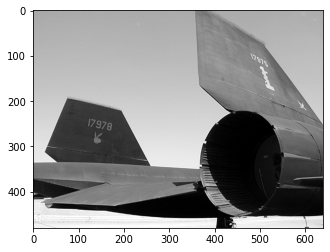

In [26]:
plt.imshow(still_img, cmap="gray")
plt.show()

In [27]:
def make_gauss_kernel_1d(extra_size, sigma):
    center = (int)(extra_size*sigma) # avoid visible truncation error
    # center = sigma
    h = np.zeros(2*center+1).astype(float)
    variance = sigma ** 2
    for i in range(h.shape[0]):
        r = center - i
        h[i] = math.exp(-0.5*(r*r)/(variance))
    return h

In [28]:
sd = 0.5
gaussian_1d_a = np.expand_dims(make_gauss_kernel_1d(3, sd), axis=1)
gaussian_1d_b = np.expand_dims(make_gauss_kernel_1d(3, sd), axis=1)
gaussian_2d = gaussian_1d_a @ gaussian_1d_b.T
print(gaussian_2d.shape)

(3, 3)


<AxesSubplot:>

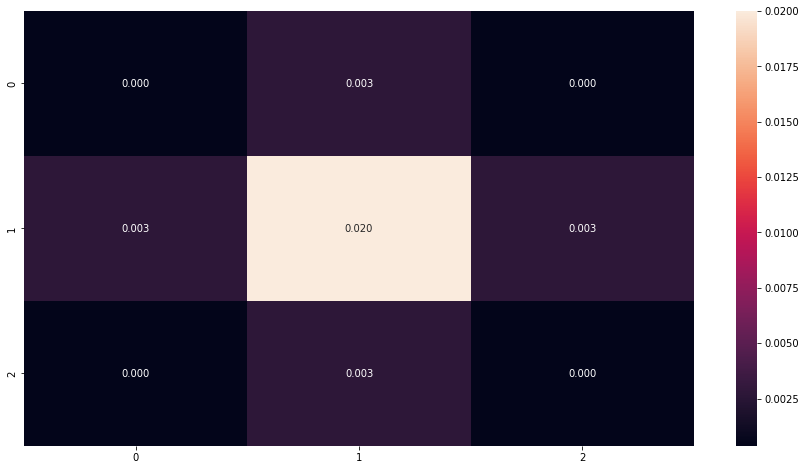

In [29]:
plt.figure(figsize = (15,8))
sns.heatmap(gaussian_2d/50, annot=True, fmt='.3f')

(480, 640)


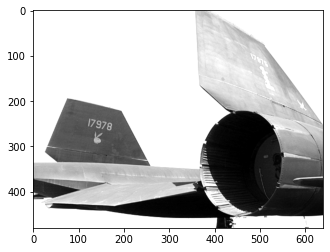

In [30]:
smooth_img = cv2.filter2D(still_img, -1, gaussian_2d, borderType=cv2.BORDER_CONSTANT)
(height, width) = smooth_img.shape
print(smooth_img.shape)
plt.imshow(smooth_img, cmap="gray")
plt.show()

In [31]:
# Derivative Filter (p.144 pdf)
# y_gradient = np.expand_dims(np.array([-0.5,0,0.5]), axis=1)
# x_gradient = y_gradient.T

In [32]:
# Sobel Filter
x_gradient = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
y_gradient = x_gradient.T

In [33]:
print(x_gradient)
print(y_gradient)

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


In [34]:
print(x_gradient.shape)
print(y_gradient.shape)

(3, 3)
(3, 3)


In [35]:
smooth_x_grad = cv2.filter2D(smooth_img, -1, x_gradient, borderType=cv2.BORDER_CONSTANT)
smooth_y_grad = cv2.filter2D(smooth_img, -1, y_gradient, borderType=cv2.BORDER_CONSTANT)

In [36]:
E_mag_img = np.hypot(smooth_x_grad, smooth_y_grad)

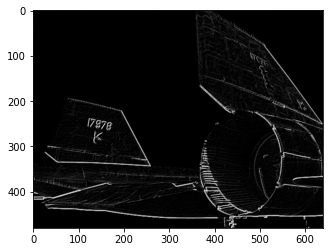

In [37]:
plt.imshow(E_mag_img, cmap="gray")

In [38]:
E_nms_img = np.zeros_like(E_mag_img)
E_bin_img = np.zeros_like(E_mag_img)

In [39]:
def get_orientation_sector(dx,dy):
    dx_r = np.cos(np.pi/8)*dx - np.sin(np.pi/8)*dy
    dy_r = np.sin(np.pi/8)*dx + np.cos(np.pi/8)*dy
    if dy_r < 0:
        dx_r = -dx_r
        dy_r = -dy_r
    if dx_r >= 0:
        if dx_r >= dy_r: s_theta = 0
        else: s_theta = 1
    else:
        if -dx_r < dy_r: s_theta = 2
        else: s_theta = 3
    return s_theta

In [40]:
test = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(test)
print(test[0,1])
print(test[0,2])
print(test[1,1])

[[1 2 3]
 [4 5 6]
 [7 8 9]]
2
3
5


In [41]:
def is_local_max(E_mag, u, v, s_theta, t_lo):
    mC = E_mag[u,v]
    if mC < t_lo: 
        return False
    if s_theta == 2:
        mL = E_mag[u-1, v]
        mR = E_mag[u+1, v]
    elif s_theta == 1:
        mL = E_mag[u-1, v-1]
        mR = E_mag[u+1, v+1]
    elif s_theta == 0:
        mL = E_mag[u, v-1]
        mR = E_mag[u, v+1]
    elif s_theta == 3:
        mL = E_mag[u-1, v+1]
        mR = E_mag[u+1, v-1]
    return (mL<= mC and mC >= mR)

In [42]:
max_E_mag = np.max(E_mag_img)
print(max_E_mag)
t_high = 0.4 * max_E_mag
t_low = 0.2 * t_high
# t_high = 150
# t_low = 50

360.5


In [43]:
for row in range(1, height-1):
    for col in range(1, width-1):
        d_x = smooth_x_grad[row, col]
        d_y = smooth_y_grad[row, col]
        s_theta_img = get_orientation_sector(d_x,d_y)
        if is_local_max(E_mag_img, row, col, s_theta_img, t_low):
            E_nms_img[row, col] = E_mag_img[row, col]

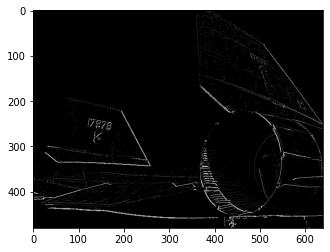

In [44]:
# E_nms = E_nms.astype(int)
plt.imshow(E_nms_img, cmap="gray")

In [45]:
def trace_and_threshold(E_nms, E_bin, row_0, col_0, t_lo):
    q = Queue()
    q.put((row_0, col_0))
    visited = np.zeros_like(E_bin)
    while q.empty() == False:
        (row_N, col_N) = q.get()
        E_bin[row_N,col_N] = 255
        row_T = max(row_N-1, 0)
        row_B = min(row_N+1, height-1)
        col_L = max(col_N-1, 0)
        col_R = min(col_N+1, width+1)
        for row in range(row_T, row_B+1):
            for col in range(col_L, col_R+1):
                if(E_nms[row, col]>=t_lo and visited[row, col]==0):
                    visited[row, col] = 1
                    q.put((row, col))
    

In [46]:
for row in range(1, height-1):
    for col in range(1, width-1):
        if(E_nms_img[row, col]>=t_high and E_bin_img[row, col]==0):
            trace_and_threshold(E_nms_img, E_bin_img, row, col, t_low)

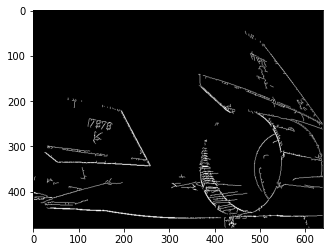

In [47]:
plt.imshow(E_bin_img, cmap="gray")

ref: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

In [48]:
def threshold(img, highThreshold, lowThreshold):

    (height, width) = img.shape
    res = np.zeros((height,width), dtype=np.int32)

    weak = 75
    strong = 255

    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res

In [49]:
E_thres = threshold(E_nms_img, t_high, t_low)

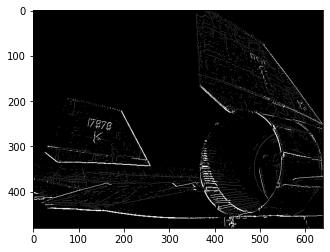

In [50]:
plt.imshow(E_thres, cmap="gray")

In [51]:
def hysteresis(img):

    height, width = img.shape
    weak = 75
    strong = 255
    
    move_direction = ((-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1))

    for i in range(1, height-1):
        for j in range(1, width-1):
            flag = False
            if (img[i,j] == weak):
                for direction in move_direction:
                    if(img[i+direction[0], j+direction[1]] == strong):
                        img[i,j] = strong
                        flag = True
                        break
                if flag == False: img[i,j] = 0
    return img

In [52]:
E_bin_img = hysteresis(E_thres)

In [53]:
test = (-1,-1)
test[0]

-1

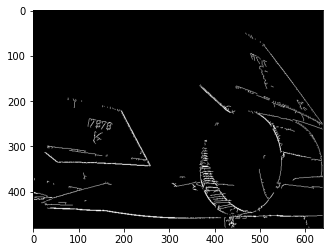

In [54]:
plt.imshow(E_bin_img, cmap="gray")